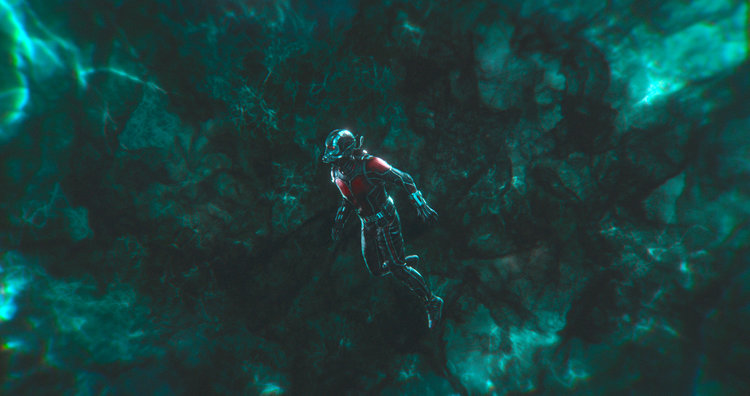

Feature Engineering + LGBM Model ( Almost everything is run in kernel Memory )

Inspired from this awesome R Kernel from Giba - https://www.kaggle.com/titericz/giba-r-data-table-simple-features-1-17-lb



# Data Preparation

In [ ]:
from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn import preprocessing
import lightgbm as lgb
import os
pd.options.display.float_format = '{:,}'.format
import gc

# # Load Data
train_df = pd.read_csv("../input/champs-scalar-coupling/train.csv")
test_df = pd.read_csv("../input/champs-scalar-coupling/test.csv")

structures = pd.read_csv("../input/champs-scalar-coupling/structures.csv")
yuk = pd.read_csv("../input/submolecularyukawapotential/structures_yukawa.csv",
                 usecols=[
                     'dist_O_0', 'dist_O_1',
                     'dist_F_0','dist_F_1',
                     'dist_C_0','dist_C_1', 'dist_C_2', 'dist_C_3',
                     'dist_H_0','dist_H_1', 'dist_H_2', 'dist_H_3'
                 ]
                 )
yuk['molecule_name'] = structures.molecule_name
yuk['atom_index'] = structures.atom_index
yuk.to_csv("yuk.csv", index=False)
del yuk

target = train_df['scalar_coupling_constant']
train_size = train_df.shape[0]

train_df = train_df\
    .merge(structures, left_on=['molecule_name', 'atom_index_0'], right_on=['molecule_name', 'atom_index'], how='left')\
    .drop(['atom_index'], axis=1)\
    .merge(structures, left_on=['molecule_name', 'atom_index_1'], right_on=['molecule_name', 'atom_index'], how='left',
           suffixes=('_0', '_1'))\
    .drop(['atom_index'], axis=1)

test_df = test_df\
    .merge(structures, left_on=['molecule_name', 'atom_index_0'], right_on=['molecule_name', 'atom_index'], how='left')\
    .drop(['atom_index'], axis=1)\
    .merge(structures, left_on=['molecule_name', 'atom_index_1'], right_on=['molecule_name', 'atom_index'], how='left',
           suffixes=('_0', '_1'))\
    .drop(['atom_index'], axis=1)

del structures
gc.collect()

In [ ]:
target = train_df.pop('scalar_coupling_constant')

features = [col for col in train_df.columns if col != 'id' and col != 'scalar_coupling_constant']

all_data = pd.concat([train_df[features], test_df[features]], axis=0, sort=False)
all_data[['molecule_name', 'atom_index_0', 'atom_index_1']].to_csv("all_data_index.csv", index=False)
test_df = test_df[['id']]
del train_df
gc.collect()

all_data['distance'] = (
    (all_data['x_0'] - all_data['x_1']).pow(2) + (all_data['y_0'] - all_data['y_1']).pow(2) + (
        all_data['z_0'] - all_data['z_1']).pow(2)
    ).pow(0.5)

In [ ]:
structures = pd.read_csv("../input/champs-scalar-coupling/structures.csv")
structures_df = structures.merge(structures, how='left', on= ['molecule_name'], suffixes = ('_0', '_1'))
del structures
gc.collect()

structures_df['distance'] = (
    (structures_df['x_0'] - structures_df['x_1']).pow(2) + (structures_df['y_0'] - structures_df['y_1']).pow(2) + (
        structures_df['z_0'] - structures_df['z_1']).pow(2)
    ).pow(0.5)

structures_df = structures_df[structures_df.atom_1.isin(['F', 'O'])]
gc.collect()

# Feature Engineering

# Distances to Nearest neighbors

In [ ]:
for atom in ['O', 'F']:
    rank_col = '{0}_rank'.format(atom)
    structures_df.loc[structures_df.atom_1 == atom, rank_col] = structures_df[structures_df.atom_1 == atom].groupby(
        ['molecule_name', 'atom_index_0'])['distance'].rank(method='first')

    atom_distance_ranks = structures_df[structures_df[rank_col] <= 2][['molecule_name', 'atom_index_0', 'distance', rank_col]]
    atom_distance_ranks[rank_col] = atom_distance_ranks[rank_col].astype(int).astype(str)
    atom_distance_ranks = atom_distance_ranks.pivot_table(
        index=['molecule_name', 'atom_index_0'], columns=[rank_col], values=['distance'])

    atom_distance_ranks.columns = [atom + '_' + '_'.join(col) for col in atom_distance_ranks.columns]

    atom_distance_ranks = atom_distance_ranks.reset_index()
    
    all_data = all_data.merge(atom_distance_ranks, on=['molecule_name', 'atom_index_0'], how='left')
    del atom_distance_ranks
    gc.collect()
    
del structures_df
gc.collect()

for atom in ['H', 'C', 'N']:
    rank_col = '{0}_rank'.format(atom)
    all_data.loc[all_data.atom_1 == atom, rank_col] = all_data[all_data.atom_1 == atom].groupby(
        ['molecule_name', 'atom_index_0'])['distance'].rank(method='first')

    atom_distance_ranks = all_data[all_data[rank_col] <= 4]
    atom_distance_ranks[rank_col] = atom_distance_ranks[rank_col].astype(int).astype(str)
    atom_distance_ranks = atom_distance_ranks.pivot_table(
        index=['molecule_name', 'atom_index_0'], columns=[rank_col], values=['distance'])
    
    atom_distance_ranks.columns = [atom + '_' + '_'.join(col) for col in atom_distance_ranks.columns]

    atom_distance_ranks = atom_distance_ranks.reset_index()
    
    all_data = all_data.merge(atom_distance_ranks, on=['molecule_name', 'atom_index_0'], how='left')
    del atom_distance_ranks
    gc.collect()

all_data.drop(columns=['C_rank', 'H_rank', 'N_rank'], inplace=True)
gc.collect()

num_features = 0
prev_features = 0 
num_features = all_data.shape[1]
all_data.iloc[:5,prev_features:num_features].head()

# Aggregations by molecule and atom position

In [ ]:
grps = [['molecule_name', 'atom_index_0'], ['molecule_name', 'atom_index_1']]
grp_columns = ['distance']
gc.collect()

for grp in grps:
    for column in grp_columns:
        stats = all_data.groupby(grp).agg(
            {column: ["mean", "min", "std", "max"]}
        )
        stats.columns = ['_'.join(col) for col in stats.columns]
        stats.columns = ['_'.join(grp) + '_' + col for col in stats.columns]

        all_data = all_data.join(stats, on=grp, how='left')

        del stats
        gc.collect()

        columns_prefix = '_'.join(grp) + '_' + column
        all_data[columns_prefix + '_mean_ratio'] = all_data[column] / all_data[columns_prefix + '_mean']
        all_data[columns_prefix + '_mean_diff'] = all_data[column] - all_data[columns_prefix + '_mean']
        all_data[columns_prefix + '_mean_diff_std_ratio'] = all_data[columns_prefix + '_mean_diff'] \
                                                            / all_data[columns_prefix + '_std']        

prev_features = num_features
num_features = all_data.shape[1]
all_data.iloc[:5,prev_features:num_features].head()

## Bonds count Features

In [ ]:
bond_data = pd.read_csv("../input/submolecular-bond-data/structures_bond.csv", usecols = [
    'molecule_name', 'atom_index', 'n_bonds', 'bond_lengths_mean', 'bond_lengths_std'])

all_data = all_data.merge(bond_data, left_on=['molecule_name', 'atom_index_0'],
                          right_on=['molecule_name', 'atom_index'], how='left')\
                   
all_data.drop(columns=['atom_index'], inplace=True)

all_data = all_data.merge(bond_data, left_on=['molecule_name', 'atom_index_1'],
                          right_on=['molecule_name', 'atom_index'], how='left', suffixes=('_0', '_1'))\

del bond_data
gc.collect()
all_data.drop(columns=['atom_index'], inplace=True)

prev_features = num_features
num_features = all_data.shape[1]
all_data.iloc[:5,prev_features:num_features].head()

structures = pd.read_csv("../input/champs-scalar-coupling/structures.csv")
atom_counts = structures.pivot_table(
    index=['molecule_name'], columns=['atom'], values='atom_index', aggfunc='count')\
    .reset_index()

atom_counts.columns = [col + '_structure_count' if col != 'molecule_name' else col for col in atom_counts.columns ]

del structures
gc.collect()

atoms_unique = all_data.pivot_table(
    index='molecule_name', columns=['atom_1'], values='atom_index_1', aggfunc='nunique')\
    .reset_index()

atoms_unique.columns = [col + '_atoms_count' if col != 'molecule_name' else col for col in atoms_unique.columns ]

all_data = all_data.merge(atom_counts, on=['molecule_name'], how='left')
all_data = all_data.merge(atoms_unique, on=['molecule_name'], how='left')

del atoms_unique, atom_counts

# Different distance metrics

In [ ]:
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

for idx in [0,1]:
    atom = 'atom_{0}'.format(idx)
    atoms = all_data[atom].values
    atoms_EN = [electronegativity[x] for x in atoms]
    atoms_rad = [atomic_radius[x] for x in atoms]

    all_data['rad_{0}'.format(idx)] = atoms_rad
    all_data['EN_{0}'.format(idx)] = atoms_EN

all_data['inverse_square'] = 1 / all_data['distance'].pow(2)
all_data['inverse_cube'] =  1 / all_data['distance'].pow(3)

all_data['inv_distance_minus_R'] = 1 / (
    all_data['distance'] - all_data['rad_0'] - all_data['rad_1']).pow(2)
all_data['inv_distance_EN'] = 1 / (
    all_data['distance']*(0.5*all_data['EN_0'] + 0.5*(all_data['EN_1']))).pow(2)

all_data['inv_distance_sum_atom_0'] = all_data.groupby(
    ['molecule_name', 'atom_index_0'])['inv_distance_minus_R'].transform('sum')
all_data['inv_distance_sum_atom_1'] = all_data.groupby(
    ['molecule_name', 'atom_index_1'])['inv_distance_minus_R'].transform('sum')

all_data['inv_distance_EN_atom_0'] = all_data.groupby(
    ['molecule_name', 'atom_index_0'])['inv_distance_EN'].transform('sum')
all_data['inv_distance_EN_atom_1'] = all_data.groupby(
    ['molecule_name', 'atom_index_1'])['inv_distance_EN'].transform('sum')

all_data['inv_distance_harmonic'] = all_data['inv_distance_sum_atom_0']*all_data['inv_distance_sum_atom_1']\
    / (all_data['inv_distance_sum_atom_0'] + all_data['inv_distance_sum_atom_1'])

all_data['inv_distance_EN_harmonic'] = all_data['inv_distance_EN_atom_0']*all_data['inv_distance_EN_atom_1']\
    / ( all_data['inv_distance_EN_atom_0'] + all_data['inv_distance_EN_atom_1'])

all_data.drop(columns=['rad_0', 'EN_0', 'rad_1', 'EN_1'
                      ], inplace=True)

del atoms_EN, atoms_rad, atoms
gc.collect()

prev_features = num_features
num_features = all_data.shape[1]
all_data.iloc[:5,prev_features:num_features].head()

In [ ]:
# Cosine Distance
all_data['dot_product'] = all_data['x_0']*all_data['x_1'] + all_data['y_0']*all_data['y_1'] + all_data['z_0']*all_data['z_1']
all_data['norm_atom_0'] = all_data['x_0'].pow(2) + all_data['y_0'].pow(2) + all_data['z_0'].pow(2)
all_data['norm_atom_1'] = all_data['x_1'].pow(2) + all_data['y_1'].pow(2) + all_data['z_1'].pow(2)

all_data['cosine'] = all_data['dot_product'] / (all_data['norm_atom_0']*all_data['norm_atom_1'])

all_data.drop(columns=['dot_product', 'norm_atom_0', 'norm_atom_1'], inplace=True)
gc.collect()

# Atom - Bond Features

In [ ]:
for idx in [0, 1]:
    atom_index = 'atom_index_{0}'.format(idx)
    
    atom_bond_counts = all_data.pivot_table(
        index=['molecule_name', atom_index], columns=['atom_1'], values='atom_0', aggfunc='count')\
    .reset_index()

    atom_bond_counts.columns = [
        col + '_bond_count_{0}'.format(idx) if col not in ['molecule_name', atom_index]
        else col for col in atom_bond_counts.columns ]

    atom_bond_distances = all_data.pivot_table(
        index=['molecule_name', atom_index], columns=['atom_1'], values='distance', aggfunc='sum')\
        .reset_index()
    
    atom_bond_distances.columns = [
        col + '_bond_distances_{0}'.format(idx) if col not in ['molecule_name', atom_index]
        else col for col in atom_bond_distances.columns ]
    
    all_data = all_data.merge(
        atom_bond_counts, on=['molecule_name', atom_index], how='left')
    all_data = all_data.merge(
        atom_bond_distances, on=['molecule_name', atom_index], how='left')
    
    all_data['C_bond_distances_{0}_mean'.format(idx)] = all_data[
        'C_bond_distances_{0}'.format(idx)] / all_data['C_bond_count_{0}'.format(idx)]
    
    all_data['H_bond_distances_{0}_mean'.format(idx)] = all_data[
        'H_bond_distances_{0}'.format(idx)] / all_data['H_bond_count_{0}'.format(idx)]
    
    all_data['N_bond_distances_{0}_mean'.format(idx)] = all_data[
        'N_bond_distances_{0}'.format(idx)] / all_data['N_bond_count_{0}'.format(idx)]

    del atom_bond_counts, atom_bond_distances
    gc.collect()

gc.collect()

prev_features = num_features
num_features = all_data.shape[1]
all_data.iloc[:5,prev_features:num_features].head()

# yukawa potential 

In [ ]:
yuk0 = pd.read_csv("yuk.csv").rename(columns={'atom_index': 'atom_index_0'})
yuk1 = pd.read_csv("yuk.csv").rename(columns={'atom_index': 'atom_index_1'})
all_data_index = pd.read_csv("all_data_index.csv")
    
all_data_index = all_data_index\
    .merge(yuk0, on=['molecule_name', 'atom_index_0'], how='left', copy=False)\
    .merge(yuk1, on=['molecule_name', 'atom_index_1'], how='left',
           suffixes=('_0', '_1'), copy=False)\

del yuk0
del yuk1
gc.collect()
all_data_index.head()

In [ ]:
for col in all_data_index.columns:
    if col not in all_data.columns:
        all_data[col] = all_data_index[col]

In [ ]:
del  all_data_index
gc.collect()

In [ ]:
types = all_data.dtypes
cat_columns = [t[0] for t in types.iteritems() if ((t[1] not in ['int64', 'float64']))]

print('Label encoding categorical columns:', cat_columns)
encoders = {}
for col in cat_columns:
    lbl = preprocessing.LabelEncoder()
    all_data[col] = lbl.fit_transform(all_data[col].astype(str))
    encoders[col] = lbl

# Model Training by types

In [ ]:
# Error function
def group_mean_log_mae(y_true, y_pred, groups, floor=1e-9):
    maes = (y_true-y_pred).abs().groupby(groups).mean()
    print((y_true-y_pred).abs().groupby(groups))
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [ ]:
features = [col for col in all_data.columns if col != 'fc' and col != 'id' and col not in ['atom_index_0', 'atom_index_1', 'scalar_coupling_constant', 'molecule_name']]

def lgbm_model_oof(train_X, train_y, test_X, n_folds, lgbm_params):
    folds = KFold(n_splits=n_folds, shuffle=False, random_state=7557)
    oof = np.zeros(len(train_X))
    predictions = np.zeros(len(test_X))
    feature_importance_df = pd.DataFrame()
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X, train_y)):
        print("Fold {}".format(fold_))
        
        trn_data = lgb.Dataset(
            train_X.iloc[trn_idx][features], label=train_y.iloc[trn_idx], free_raw_data=True)
        val_data = lgb.Dataset(
            train_X.iloc[val_idx][features], label=train_y.iloc[val_idx], free_raw_data=True)

        num_round = 1000
        clf = lgb.train(lgbm_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000,
                        early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(train_X.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test_X, num_iteration=clf.best_iteration) / folds.n_splits
        
        del trn_data, val_data
        gc.collect()    
    return predictions, oof, feature_importance_df

In [ ]:
params_dict = {}
params_dict['1JHC'] = param = {
    'num_leaves': 150,
    'objective': 'huber',
    'colsample_bytree': 0.5,
    'subsample': 0.9,
    'eta': 0.05,
    'n_estimators': 20000,
    'metric': 'mae'
}

params_dict['2JHC'] = param = {
    'num_leaves': 200,
    'objective': 'huber',
    'colsample_bytree': 0.5,
    'subsample': 0.9,
    'eta': 0.05,
    'n_estimators': 10000,
    'metric': 'mae'
}

params_dict['1JHN'] = {
    'num_leaves': 200,
    'objective': 'huber',
    'colsample_bytree': 0.5,
    'subsample': 0.9,
    'eta': 0.05,
    'n_estimators': 10000,
    'metric': 'mae'
}

In [ ]:
predictions_type = np.zeros(len(test_df))
feature_importance_dfs = {}
oof_type = np.zeros(train_size)

for typ in  all_data.type.unique():
    gc.collect()
    print('Predicting type:', typ)
    print(encoders['type'].classes_[typ])
    if encoders['type'].classes_[typ] in params_dict.keys():
        param = params_dict[encoders['type'].classes_[typ]]
    else:
        param = {
    'num_leaves': 200,
    'min_child_samples': 79,
    'objective': 'huber',
    'colsample_bytree': 0.75,
    'subsample': 0.8,
    'eta': 0.3,
    'n_estimators': 10000,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'metric': 'mae'
    }
        
    print(param)
    type_df_train = all_data[:train_size][all_data.type == typ]
    type_df_train_indices = type_df_train[type_df_train.type == typ].index
    type_target = target.iloc[type_df_train_indices]

    type_df_test = all_data[train_size:].reset_index().drop(columns=['index'])
    type_df_test = type_df_test[type_df_test.type == typ]
    type_df_test_indices = type_df_test[type_df_test.type == typ].index
    
    predictions, oof, type_feature_importance_df  = lgbm_model_oof(
        type_df_train[features], type_target, type_df_test[features], 3, param)
    
    predictions_type[type_df_test_indices] += predictions
    oof_type[type_df_train_indices] += oof
    
    feature_importance_dfs[typ] = type_feature_importance_df
    print(
        type_feature_importance_df.groupby(['Feature'])[['importance']].mean().sort_values(
        "importance", ascending=False).head(10)
         )

    del type_df_train, type_target, type_df_test
    gc.collect()

In [ ]:
types = encoders['type'].inverse_transform(all_data[:train_size]['type'])

maes = (target-oof_type).abs().groupby(types).mean()
floor=1e-9
print('Log of Mean absolute errors on VAL:')
print(np.log(maes.map(lambda x: max(x, floor))))
print('')
print('Overal Log Mae:')
print(np.log(maes.map(lambda x: max(x, floor))).mean())

In [ ]:
test_df['scalar_coupling_constant'] = predictions_type
test_df[['id', 'scalar_coupling_constant']].to_csv('submission.csv', index=False)

# Feature Importances by Type

In [ ]:
for key, value in feature_importance_dfs.items():
    print('Feature Importance for type ', encoders['type'].classes_[key], ' :')
    print(
    value.groupby(['Feature'])[['importance']].mean().sort_values(
        "importance", ascending=False).head(20)
         )